In [29]:
from random import randint, sample, random, seed
from itertools import chain
from scipy import sparse
from scipy.special import expit
import numpy as np
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from numpy.random import choice, normal
from numpy import array
from math import floor, ceil

%matplotlib inline

print = PrettyPrinter(indent=4).pprint

[14, 12, 8, 11, 12, 8, 8, 11, 14, 9, 10, 10, 14, 13, 12, 9, 13, 9, 13, 5]
[0, 4, 9, 15]
[0, 45, 107, 197]
[   [   (   14,
            {   2: (0.47867824634867706, 0.3, 2),
                3: (0.18511861001567542, 0.3, 3)}),
        (   12,
            {   1: (-0.1967012083951174, 0.3, 2),
                2: (-0.3823579563593482, 0.3, 4)}),
        (   8,
            {   1: (0.4561640434847263, 0.3, 3),
                3: (-0.029095397951029, 0.3, 4)}),
        (   11,
            {   None: {   1: (0.37135248921768305, 0.3, 3),
                          2: (0.2457733065938773, 0.3, 3),
                          3: (0.48502306422698316, 0.3, 2)},
                1: (-0.3906195367896649, 0.3, 3),
                3: (0.4763341297746475, 0.3, 2)})],
    [   (   12,
            {   1: (0.3677282959786423, 0.3, 4),
                2: (0.28535953724267205, 0.3, 1)}),
        (   8,
            {   2: (-0.2750265495145773, 0.3, 3),
                3: (0.13912208321991182, 0.3, 4)}),
        (  

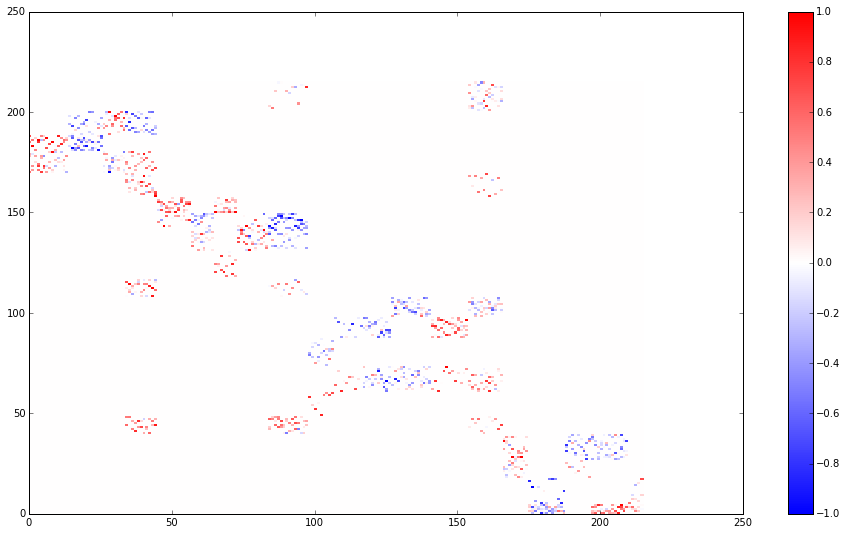

In [56]:
_INITIAL_UNITS = 4

_INITIAL_MIN_NODES = 8

_INITIAL_MAX_NODES = 14

_INITIAL_LAYERS_MIN = 3

_INITIAL_LAYERS_MAX = 6

_INITIAL_MU_RANGE = 0.5

_INITIAL_SIGMA = 0.3

_INITIAL_OUTDEGREE_MIN = 1

_INITIAL_OUTDEGREE_MAX = 4

_INITIAL_PROJECTIONS_PER_LAYER = 2

_N_INPUT_UNITS = 14

_N_OUTPUT_UNITS = 5


def _rand_range(rng):
    return random() * 2 * rng - rng

def _node_index(nodes, to_layer):
    #print(to_layer)
    start = sum(nodes[:to_layer])
    stop = start + nodes[to_layer]
    return list(range(start,stop))

def _projections(out_degree=4.4, n_projecting_nodes=10):
    low = int(floor(out_degree))
    high = int(ceil(out_degree))
    pl = high - out_degree
    ph = 1 - pl
    return array(choice([low, high], n_projecting_nodes, p=[pl, ph]), dtype=int)

def _create_initial_structure():
    """Create the inital randomized structure for the agent.

    For the structure, see the ANNStructuredAgent configuration below.

    """
    #seed(11)
    # Create units (populations or columns) and layers with their nodes count.
    structure = [
        [(randint(_INITIAL_MIN_NODES, _INITIAL_MAX_NODES), {})
            for _ in range(randint(_INITIAL_LAYERS_MIN, _INITIAL_LAYERS_MAX))]
        for _ in range(_INITIAL_UNITS)
    ]
    
    structure[0][0] = (_N_INPUT_UNITS, {})    
    structure[-1][-1] = (_N_OUTPUT_UNITS, {})

    nodes = list(chain.from_iterable([[i[0] for i in j] for j in structure]))
    print(nodes)
    n_layers = len(nodes)
    n_nodes = sum(nodes)
    
    wheight_matrix = sparse.lil_matrix((n_nodes, n_nodes))
    wheight_matrix_normal = np.zeros((n_nodes, n_nodes))

    # For each layer in each unit: add the configuration (connections).
    
    layers_per_unit = [len(structure[j]) for j in range(len(structure))]
    accum_layers_per_unit = [sum(layers_per_unit[0:i]) for i in range(len(layers_per_unit))]
    print(accum_layers_per_unit)
    
    startnode_in_units = [sum(nodes[0:j * len(structure[j-1])]) for j in range(len(structure))]
    print(startnode_in_units)

    cur_layer = 0;
    for j, unit in enumerate(structure):
        for i, (num_nodes, conns) in enumerate(unit):
            # Connect this layer to other layers in the same unit.
            # j = unit index
            
            # i = lager index
            
            # num_nodes är antalet noder i detta lager
            
            # len(unit) antal lager i aktuell unit 
            
            others = sample([n for n in range(len(unit)) if n != 0], _INITIAL_PROJECTIONS_PER_LAYER)
            
            #others är en slumpad lista med lager i denna unit utom fösta(input-lagret)
            
            from_nodes = _node_index(nodes, i + accum_layers_per_unit[j])
            
            # from_nodes är en lista med alla "från-noder" i aktuellt i
            
            for o in others:
                conns[o] = (
                    _rand_range(_INITIAL_MU_RANGE), _INITIAL_SIGMA,
                    randint(_INITIAL_OUTDEGREE_MIN, _INITIAL_OUTDEGREE_MAX))
                to_layer = o + accum_layers_per_unit[j]
                #print("from " + str(from_nodes) + " to layer: " + str(to_layer))
                for from_node, n_projections in zip(from_nodes, _projections(conns[o][2], num_nodes)):
                    for to_node in choice(_node_index(nodes, to_layer), n_projections):
                        wheight = normal(conns[o][0], conns[o][1], 1)[0]
                        wheight_matrix[to_node, from_node] = wheight
                        wheight_matrix_normal[to_node][from_node] = wheight

            # Connect the last layer of the current unit to other units.
            # TODO: Add wheights for this connection
            if i == len(unit) - 1 and j < len(structure) - 1:
                others = [n for n in range(len(structure)) if n != j]
                conns_to_layer = {
                    n: (abs(_rand_range(_INITIAL_MU_RANGE)), _INITIAL_SIGMA,
                        randint(
                            _INITIAL_OUTDEGREE_MIN, _INITIAL_OUTDEGREE_MAX))
                    for n in others}
                conns[None] = conns_to_layer
                
                # others är en lista med alla andra units utom denna
                # from_nodes innehåller detta lagers output-noder
                # för vardera unit i others: skapa en slumpad lista med noder i dess inputlager
                for to_unit in others:
                    for from_node, n_projections in zip(from_nodes, _projections(conns_to_layer[to_unit][2], num_nodes)):
                        for to_node in choice(_node_index(nodes, accum_layers_per_unit[to_unit]), n_projections):
                            wheight = normal(conns_to_layer[to_unit][0], conns_to_layer[to_unit][1], 1)[0]
                            wheight_matrix[to_node, from_node] = wheight
                            wheight_matrix_normal[to_node][from_node] = wheight
                            
                            # to_nodes
                            # 
                            # n 

    print(structure)
    return wheight_matrix, wheight_matrix_normal

w_matrix, data = _create_initial_structure()



plt.figure(figsize=(16,9))
heat = plt.pcolor(np.flipud(data), cmap='bwr', vmax=1, vmin=-1)
bar = plt.colorbar()
# plt.savefig('wheight_matrix.pdf', type='pdf')

In [4]:
def _create_conections(n_nodes=10):
    
    test = sparse.lil_matrix((n_nodes, n_nodes))
#     indexes = np.array(sample(range(n_nodes), 5))

    list = np.random.random_integers(1,5,n_nodes)
    proj = projections()
    test[0, 1] = 1

    print(list)

    out = test.dot(list)
    
    print(out)

_create_conections(n_nodes, structure)

NameError: name 'n_nodes' is not defined

In [ ]:
def foo(result, i):
    i += 1
    print((i, result))
    if i == 10: 
        return result
    else: 
        foo(expit(result), i)

foo(0, 0)
1-1/np.e

In [ ]:
for i,j in zip(range(5,10),range(5)):
    print((i, j))

In [ ]:
normal(1,0.2,10)

In [ ]:
x = np.linspace(-10,10,100)

shift = 5
frac = 5

plt.figure(figsize=(19,9))
plt.plot(x, expit((x)*frac-shift))